# Init

In [ ]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [ ]:
env = gym.make('Blackjack-v0')
# env = gym.make('gym_foo:foo-v0')

In [ ]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


States:
*  Players current sum: [0,31] i.e. 32 states
*  Dealer's face up card: [1,10] i.e. 10 states
*  Whether the player has a usable ace or not: [0,1] i.e. 2 states

Actions:
* Either stand or hit: [0,1] i.e 0 for stand , 1 for hit

In [ ]:
#Random Policy:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state) 
        action = env.action_space.sample() # takes random action from environment's action space
        state, reward, done, info = env.step(action) # OpenAI gym gives feedback in this tuple form : state,reward,if_done?,other relevant info
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(13, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(20, 10, False)
Game has ended! Your Reward:  1.0
You won :)

(15, 5, True)
(19, 5, True)
(19, 5, False)
Game has ended! Your Reward:  -1.0
You lost :(



# Task 5

Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.

Будем использовать случайную модель

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [ ]:
for i in range(5):
    episode = generate_episode_from_limit_stochastic(env)
    states, actions, rewards = zip(*episode)
    print(rewards[-1])
    print(episode)

-1.0
[((14, 9, False), 1, -1.0)]
-1.0
[((9, 1, False), 0, -1.0)]
-1.0
[((8, 4, False), 0, -1.0)]
1.0
[((6, 9, False), 1, 0.0), ((14, 9, False), 1, 0.0), ((18, 9, False), 0, 1.0)]
-1.0
[((14, 2, False), 0, -1.0)]


Сделаем словари с наградами и числом попаданий в состояние 

In [ ]:
def create_q(env, num_episodes, generate_episode):
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
               
        # generate an episode
        episode = generate_episode(env)
        # print('\n Episode: \n')

        states, actions, _ = zip(*episode)
        # print(rewards)

        for i, state in enumerate(states): #ever-visit
            Q[state][actions[i]] = 0
    return Q

In [ ]:
Q = create_q(env, 10_000, generate_episode_from_limit_stochastic)

Episode 10000/10000.

In [ ]:
len(Q.keys())

280

In [ ]:
n = len(Q.keys())

Q_list = list(Q.keys())

In [ ]:
from collections import defaultdict

Q_new = defaultdict(dict)
for i in range(n):
    for j in range(n):
          Q_new[Q_list[i]][Q_list[j]] = 0

In [ ]:
Q_rew = defaultdict(dict)
for i in range(n):
    for j in range(n):
          Q_rew[Q_list[i]][Q_list[j]] = 0

## Monte Carlo estimation

С помощью Монте-Карло посчитаем переходы между состояниями и награды, которые получит игрок

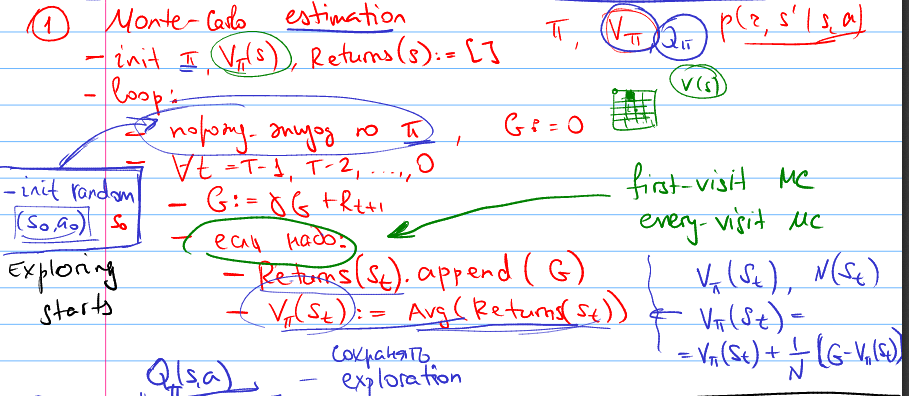

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, Q_new, Q_rew):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    rewards_list = []
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            
        # generate an episode
        episode = generate_episode(env)
        # print('\n Episode: \n')
        # print(episode)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # print(rewards)
        # print('\n actions: \n')
        # print(actions)
        rewards_list.append(rewards[-1])

        for m in range(len(states)):
            if m != 0:
                prev_state = states[m-1]
                Q_new[states[m]][prev_state] += 1
                Q_rew[states[m]][prev_state] += rewards[m]
            if len(states) == 1:
                Q_new[states[0]][states[0]] += 1
                Q_rew[states[0]][states[0]] += rewards[m]
        

        discounts = np.array([1**i for i in range(len(rewards)+1)]) 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states): #ever-visit
            returns_sum[state][actions[i]] += np.sum(rewards[i:]) # смотрим с конца
            # Avg(Returns)
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        # print('\n Returns(S, A): \n')
        # print(returns_sum)
        
        # print('\n Q: \n')
        # print(Q)

    return Q, rewards_list, Q_new, Q_rew

In [ ]:
Q2, rew, QQ_new, QQ_rew = mc_prediction_q(env, 500_000, generate_episode_from_limit_stochastic, Q_new, Q_rew)

Episode 500000/500000.

Нормируем и получим вероятности

In [ ]:
norm_sum = 0
for i in range(n):
    for j in range(n):
        if QQ_new[Q_list[i]][Q_list[j]] > 0:
            norm_sum += QQ_new[Q_list[i]][Q_list[j]]

norm_sum

533217

In [ ]:
for i in range(n):
    for j in range(n):
        if QQ_rew[Q_list[i]][Q_list[j]] != 0:
            QQ_rew[Q_list[i]][Q_list[j]] /= QQ_new[Q_list[i]][Q_list[j]]

In [ ]:
for i in range(n):
    for j in range(n):
        if QQ_new[Q_list[i]][Q_list[j]] > 0:
            QQ_new[Q_list[i]][Q_list[j]] /= norm_sum

In [ ]:
# rew_sum = 0
# for i in range(n):
#     for j in range(n):
#         if QQ_rew[Q_list[i]][Q_list[j]] > 0:
#             rew_sum += QQ_rew[Q_list[i]][Q_list[j]]

# rew_sum

## Policy evaluation

Примением алгоритм для нахождения оптимального значения для функции V

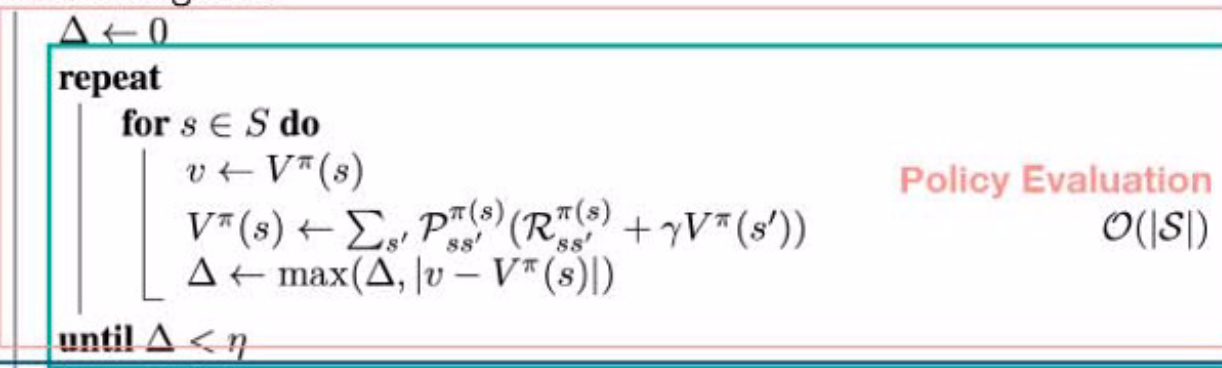

In [ ]:
def policy_eval(theta=0.001):
    # Initialize thel value function
    V = defaultdict(dict) #np.zeros(n)
    for i in range(n):
        V[Q_list[i]] = 0
    iter = 0
    # While our value function is worse than the threshold theta
    while True:
        # Keep track of the update done in value function
        delta = 0
        # For each state, look ahead one step at each possible action and next state
        for i in range(n):
            v = 0
            for j in range(n):
                v += Q_new[Q_list[i]][Q_list[j]] * (Q_rew[Q_list[i]][Q_list[j]] +  V[Q_list[i]]) # P[s, a, s']*(R(s,a,s')+γV[s'])
                    # How much our value function changed across any states .  
            delta = max(delta, np.abs(v - V[Q_list[i]]))
            V[Q_list[i]] = v

        iter += 1
        # Stop evaluating once our value function update is below a threshold
        if delta < theta:
            break
    return np.array(V), iter

In [ ]:
arr, it = policy_eval(0.00000000000001)

In [ ]:
it

10

In [ ]:
arr

array(defaultdict(<class 'dict'>, {(16, 10, False): -0.017597495740990697, (13, 3, False): -0.002344433714578869, (16, 3, False): -0.003092978052876904, (4, 2, False): -4.877014816746168e-05, (6, 2, False): -0.00014450622971986436, (19, 4, False): -0.0014625042223912227, (18, 10, False): -0.01335758256208738, (12, 6, False): -0.0017496064328202034, (19, 8, False): -0.0006075551941252055, (18, 9, False): -0.003183799799950932, (13, 2, False): -0.0024779315117833753, (14, 2, False): -0.002680939857142318, (20, 2, False): -0.0014484110079236606, (21, 2, False): -0.0001261112376406282, (13, 6, False): -0.0021971970178472754, (20, 10, False): -0.01007558148604583, (12, 1, False): -0.0040177376234450364, (16, 9, True): -0.00023830253538886472, (19, 1, False): -0.003177766203965792, (21, 1, False): -0.0005986220398328376, (20, 5, False): -0.0012973337424195932, (17, 5, False): -0.002378036006484866, (19, 10, False): -0.01155721503995324, (14, 4, True): -9.194177271243239e-05, (14, 4, False): 